# Local chiral potentials

This notebook is dedicated to local chiral potentials. It creates the figures in the manuscript associated with this potential.

We use here the local chiral potentials [GT+](https://arxiv.org/abs/1406.0454) up to N2LO, which are commonly used in quantum Monte Carlo (QMC) calculations of finite nuclei and infinite matter. 

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./modules")
output_dir = "./output"

import numpy as np
import matplotlib.pyplot as plt
from Potential import Potential, chiral, chiral_affine
from Channel import Channel
from ScatteringExp import ScatteringExp
from RseSolver import RseSolver
from Grid import Grid
from plots.rc_params import *
from string import ascii_lowercase as alphabet
from constants import hbarc, cm


## Affine version

We have developed an affine decomposed version of the original `C++` source code provided by the developers. It matches the original, non-affine decomposed version of the code very well. This section illustrates the workflow.

First, we obtain the parameter-independent portion of the chiral potentials:

In [2]:
potentialArgs = {"label": "chiral", "potId": 213, "mpi":140}
# channel = Channel(S=1, L=2, LL=2, J=1, channel=0)  # pick here the channel
channel = Channel(S=0, L=0, LL=0, J=0, channel=0)  # pick here the channel
potential = Potential(channel, **potentialArgs)
r = 1 # fm
aff_decomp = chiral_affine(r, channel, **potentialArgs)
aff_decomp

array([-128.68875578,   18.8563818 ,  -56.56914541,   75.42552722,
         75.42552722, -226.27658165, -226.27658165,    0.        ,
        -75.42552722,  -75.42552722,    0.        ,    0.        ])

Note that several terms are equivalent or multiple of each other. This is because of the partial wave decomposition. 

Next, we read in the values of the low-energy couplings (LECs) from the provided data (i.e., `yaml`) files:

In [3]:
import yaml
with open("data/localGT+_lecs_order_2_R0_1.0_lam_1000.yaml", 'r') as stream:
    lecs = yaml.safe_load(stream)
lecs

{'potId': 213,
 'order': 2,
 'R0': 1.0,
 'lambda': 1000,
 'CS': 5.4385,
 'CNN': 0.04344,
 'CPP': 0.062963,
 'CT': 0.27672,
 'C1': -0.14084,
 'C2': 0.04243,
 'C3': -0.12338,
 'C4': 0.11018,
 'C5': -2.11254,
 'C6': 0.15898,
 'C7': -0.26994}

Next, we reconstruct a local chiral potential using the affine decomposition. This involves a dot product. We also evaluate the potential using the function provided by the developers. The two functions should result in the same results:

In [4]:
lec_vec = np.array([1.] + [lecs[elem] for elem in ("CS", "CT", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "CNN", "CPP")])
potval_via_aff_decomp = aff_decomp @ lec_vec
potval = chiral(r, channel,  mpi=potentialArgs["mpi"], **lecs)
diff = np.abs(potval_via_aff_decomp - potval)
assert diff < 1e-11, f"difference (aff. vs. nonaffine evaluation): {diff:e} MeV"

For completeness, let's plot the potential in the requested partial-wave channel:

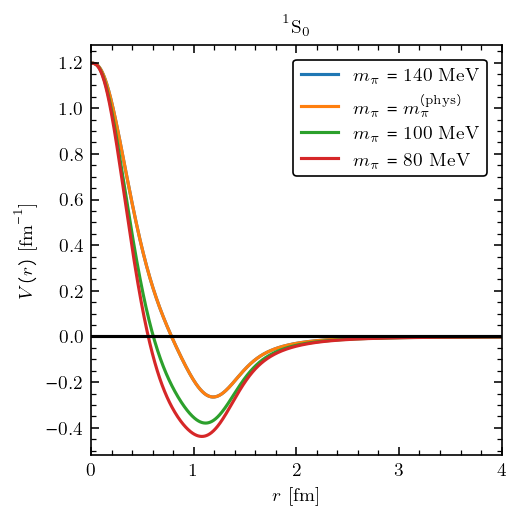

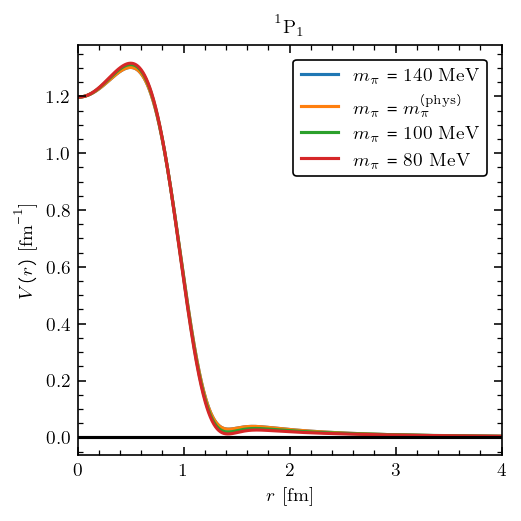

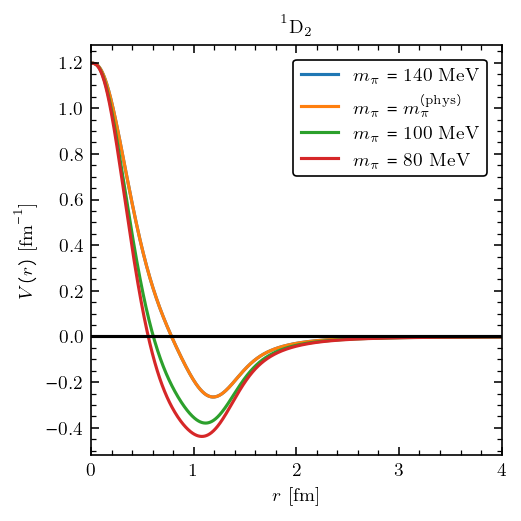

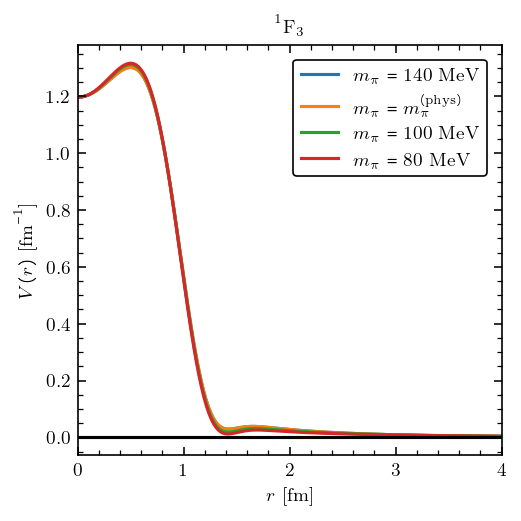

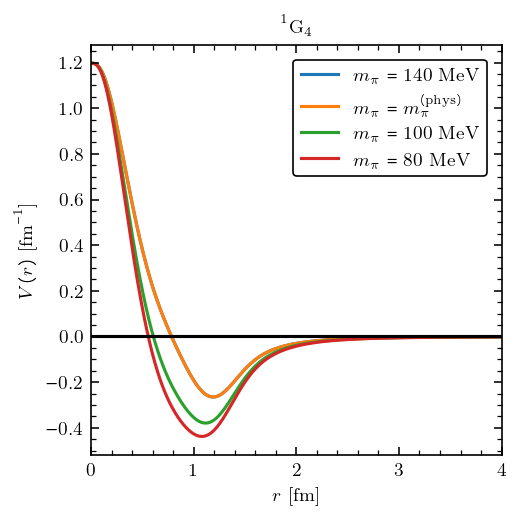

In [13]:
from constants import hbarc
rarr = np.linspace(0., 4., 1000)
lvalues = [0, 1, 2, 3, 4] # , 8] # , 12]
channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 

mpi_arr = (140, -1, 100, 80)
for channel in channels:
    fig, ax = plt.subplots(1,1, sharex=True, figsize=(8.6*cm,8.6*cm), constrained_layout=True)
    for mpi in mpi_arr:
        yarr = np.array([chiral(r, channel, mpi=mpi, **lecs) for r in rarr])
        label = f"$m_\pi = {mpi}$ MeV" if mpi > 0 else "$m_\pi = m_\pi^\mathrm{(phys)}$"
        ax.plot(rarr, yarr / hbarc, label=label)
    ax.axhline(0, c="k")
    ax.set_xlabel("$r$ [fm]")
    ax.set_xlim(0,4)
    ax.set_ylabel("$V(r)$ [fm$^{-1}$]")
    ax.set_title(channel.spectNotationTeX)
    ax.legend()
    fig.savefig(f"{output_dir}/potential_mpi_{channel.spectNotation}.pdf")

The figure can be compared with Figure 14 in [Hoppe et al.](https://arxiv.org/pdf/1707.06438) (2017).

## Benchmarking the matrix Numerov method (Figure 2)

In [10]:
# potentialArgs = {"label": "chiral", "potId": 213}
trainingLecList, validationLecList = Potential.getSampleLecs(potentialArgs["label"])
rmin, rmatch = 1e-12, 12
grid = Grid(rmin, rmatch, numIntervals=1, numPointsPerInterval=1000,
            type="linear", test=False) 
solver_args = dict(asympParam="K", matching=True)

def f(E_MeV, channel, mpi, inhomogeneous=True):
    potentialArgs = {"label": "chiral", "potId": 213, "mpi":mpi}
    potential = Potential(channel, **potentialArgs)
    scattExp = ScatteringExp(E_MeV=E_MeV, potential=potential)
    solver = RseSolver(scattExp, grid, inhomogeneous=inhomogeneous)
    scattSols_rk45 = solver.solve(lecList=validationLecList, method="RK45", **solver_args)
    return scattSols_rk45[0]

working on 1S0
working on 1P1
working on 1D2
working on 1F3
working on 1G4


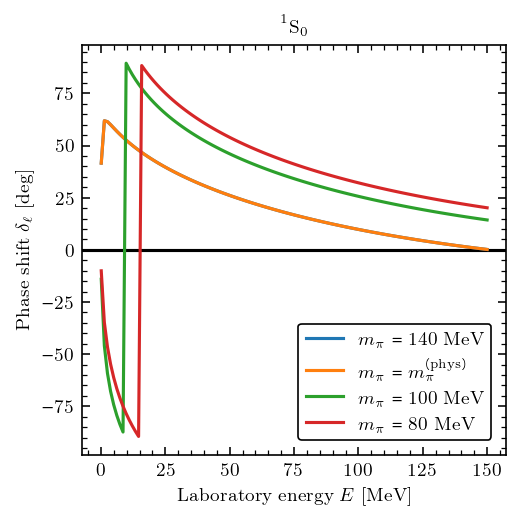

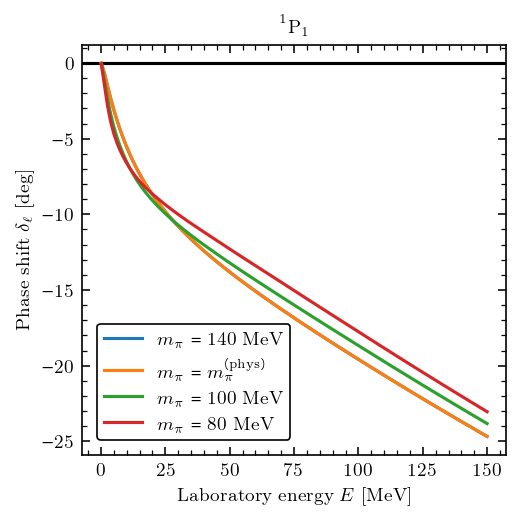

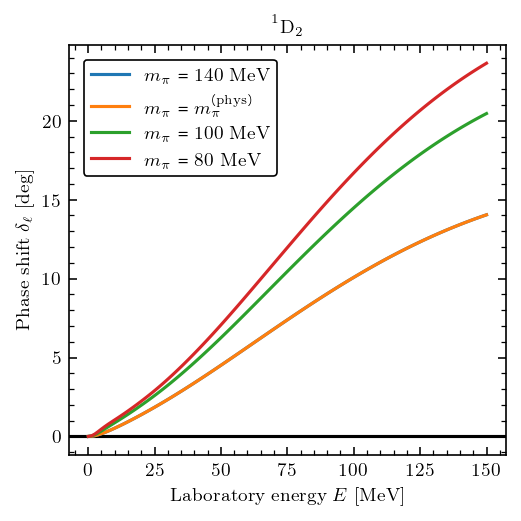

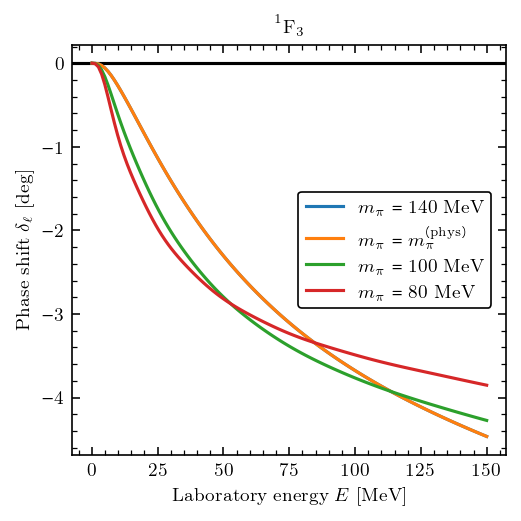

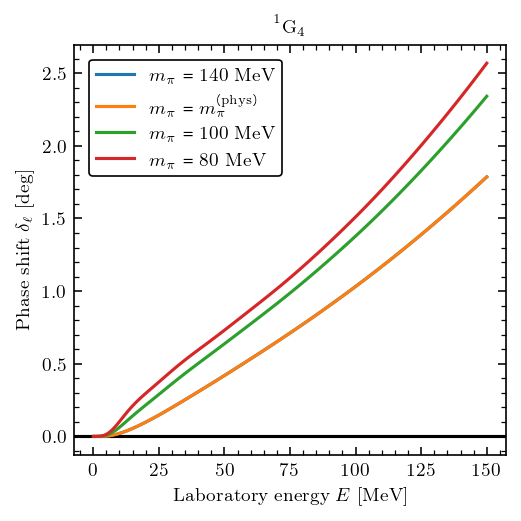

In [11]:
inhomogeneous = True
lvalues = [0, 1, 2, 3, 4] # , 8] # , 12]
channels = [Channel(S=0, L=l, LL=l, J=l, channel=0) for l in lvalues]  # only spin 0 
energies_MeV = np.linspace(1e-1, 150, 125)

for channel in channels:
    fig, ax = plt.subplots(1,1, sharex=True, figsize=(8.6*cm,8.6*cm), constrained_layout=True)
    print("working on", channel.spectNotation)
    for mpi in mpi_arr: 
        ret_raw = []
        for E_MeV in energies_MeV:
            ret_raw.append(f(E_MeV=E_MeV, channel=channel, mpi=mpi, inhomogeneous=inhomogeneous))

        ret = np.array([elem.Lmatrix.phaseShift for elem in ret_raw])
        label = f"$m_\pi = {mpi}$ MeV" if mpi > 0 else "$m_\pi = m_\pi^\mathrm{(phys)}$"
        ax.plot(energies_MeV, ret, label=label)

    ax.axhline(0, color = "k", zorder=0)
    ax.set_title(channel.spectNotationTeX)
    ax.set_ylabel("Phase shift $\delta_\ell$ [deg]")
    ax.set_xlabel("Laboratory energy $E$ [MeV]")
    ax.legend(loc="best")
    fig.savefig(f"{output_dir}/phaseshift_mpi_{channel.spectNotation}.pdf")